In [ ]:
# This class tests whether the tensorflow and autograd versions give identical outputs for a simple least squared loss function

In [1]:
from autograd import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from optimizers.autograd.lma import LMA as LMAag
from optimizers.tensorflow.lma import LMA as LMAtf

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
z_true = np.random.randn(3,10).astype('float32')

random_mat = np.random.randn(3,3)
random_symmetric_mat = random_mat + random_mat.T
evals, evecs = np.linalg.eig(random_symmetric_mat)
affine_transform = evecs

y_true = affine_transform @ z_true
y_true_flat = y_true.flatten()

In [4]:
def y_pred(z_flat):
    z_arr = np.reshape(z_flat, (3, -1))
    return (affine_transform @ z_arr).flatten()

def loss_fn(y):
    return 0.5 * np.sum((y - y_true_flat)**2)

In [5]:
z_guess = np.random.randn(30).astype('float32')

In [6]:
# Testing the autograd implementations

In [16]:
np.finfo('float32').eps * np.linalg.norm(out1), np.linalg.norm(out1)

(6.773821263302893e-07, 5.6822931239912755)

In [7]:
ag_lma1 = LMAag(z_guess, y_pred, loss_fn, squared_loss=True, damping_factor=1., cg_tol=1e-5)
ag_lma2 = LMAag(z_guess, y_pred, loss_fn, squared_loss=False, damping_factor=1., cg_tol=1e-5)

In [8]:
ag_losses1 = []
ag_losses2 = []
for i in range(20):
    out1 = ag_lma1.minimize()
    out2 = ag_lma2.minimize()
    print(i, loss_fn(y_pred(out1)), loss_fn(y_pred(out2)))
    ag_losses1.append(loss_fn(y_pred(out1)))
    ag_losses2.append(loss_fn(y_pred(out2)))

0 9.167177748686576 9.167177748686576
1 2.2917944371716437 2.2917944371716437
2 0.572948609292911 0.572948609292911
3 0.14323715232322787 0.14323715232322787
4 0.03580928808080695 0.03580928808080695
5 0.008952322020201709 0.008952322020201709
6 0.002238080505050427 0.002238080505050427
7 0.0005595201262626123 0.0005595201262626123
8 0.0001398800315656502 0.0001398800315656502
9 3.497000789141121e-05 3.497000789141121e-05
10 8.74250197285255e-06 8.74250197285255e-06
11 2.18562549321346e-06 2.18562549321346e-06
12 5.464063733034342e-07 5.464063733034342e-07
Stopping iteration. Very low loss value: 5.464063733034342e-07
Stopping iteration. Very low loss value: 5.464063733034342e-07
13 5.464063733034342e-07 5.464063733034342e-07
Stopping iteration. Very low loss value: 5.464063733034342e-07
Stopping iteration. Very low loss value: 5.464063733034342e-07
14 5.464063733034342e-07 5.464063733034342e-07
Stopping iteration. Very low loss value: 5.464063733034342e-07
Stopping iteration. Very low

In [9]:
# Tensorflow test

In [10]:
tf.reset_default_graph()
var1 = tf.get_variable('var1', dtype=tf.float32, initializer=z_guess)
var2 = tf.get_variable('var2', dtype=tf.float32, initializer=z_guess)

tf_y_true = tf.convert_to_tensor(y_true_flat, dtype='float32', name='y_true')
tf_affine_transform = tf.convert_to_tensor(affine_transform, dtype='float32', name='affine_transform')

def tf_y_pred(z):
    return tf.reshape(tf_affine_transform @ tf.reshape(z, [3, -1]), [-1])
def tf_loss(y_pred):
    return 0.5 * tf.reduce_sum((tf_y_true - y_pred)**2)

preds1 = tf_y_pred(var1)
preds2 = tf_y_pred(var2)
loss_tensor1 = tf_loss(preds1)
loss_tensor2 = tf_loss(preds2)

tf_lma1 = LMAtf(var1, tf_y_pred, tf_loss, name='opt1', squared_loss=True, cg_tol=1e-5)
tf_lma2 = LMAtf(var2, tf_y_pred, tf_loss, name='opt2', squared_loss=False, cg_tol=1e-5)

tf_lma1_min = tf_lma1.minimize()
tf_lma2_min = tf_lma2.minimize()
session = tf.Session()
session.run(tf.global_variables_initializer())

In [11]:
tf_losses1 = []
tf_losses2 = []
for i in range(50):
    session.run([tf_lma1_min, tf_lma2_min])
    lossval1, lossval2 = session.run([loss_tensor1, loss_tensor2])
    print(i, lossval1, lossval2)
    tf_losses1.append(lossval1)
    tf_losses2.append(lossval2)
    

0 9.167178 9.167178
1 2.2917948 2.2917948
2 0.57294863 0.57294863
3 0.14323714 0.14323714
4 0.035809275 0.035809275
5 0.008952325 0.008952325
6 0.00223808 0.00223808
7 0.0005595188 0.0005595188
8 0.00013988095 0.00013988095
9 3.4968543e-05 3.4968543e-05
10 8.743125e-06 8.743125e-06
11 2.1854016e-06 2.1854016e-06
12 5.462999e-07 5.462999e-07
13 5.5469518e-14 5.5469518e-14
14 5.4656095e-07 5.4656095e-07
15 2.1857954e-06 2.1857954e-06
16 5.4657676e-07 5.4657676e-07
17 5.751649e-14 5.751649e-14
18 5.462572e-07 5.462572e-07
19 2.1852825e-06 2.1852825e-06
20 5.4626366e-07 5.4626366e-07
21 5.6628313e-14 5.6628313e-14
22 5.465526e-07 5.465526e-07
23 2.1856586e-06 2.1856586e-06
24 5.465742e-07 5.465742e-07
25 5.5629112e-14 5.5629112e-14
26 5.4622944e-07 5.4622944e-07
27 2.1851545e-06 2.1851545e-06
28 5.4624263e-07 5.4624263e-07
29 5.740547e-14 5.740547e-14
30 5.4651014e-07 5.4651014e-07
31 2.1855644e-06 2.1855644e-06
32 5.4650866e-07 5.4650866e-07
33 5.6628313e-14 5.6628313e-14
34 5.462246e-07 

In [268]:
ag_losses1[:5], tf_losses1[:5], tf_losses2[:5]

([7.678560146004725,
  1.9196400365011812,
  0.4799100091252957,
  0.11997750228132388,
  0.029994375570330967],
 [7.6785603, 1.9196398, 0.47990993, 0.11997749, 0.029994376],
 [7.6785603, 1.9196398, 0.47990993, 0.11997749, 0.029994376])

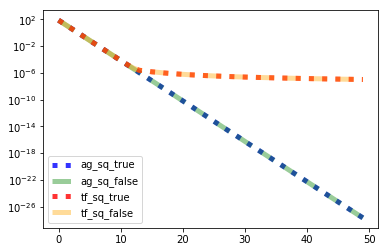

In [255]:
# Any discrepancy here is because curveball requires a matrix inversion step
# the matrix becomes singular fairly often
# I tried calculating the pseudo inverse myself, but all the approach I tried for this 
# in tensorflow game solutions less stable and accurate than the numpy counterpart.

plt.plot(ag_losses1, color='blue', ls=':', linewidth=5.0, alpha=0.8, label='ag_sq_true')
plt.plot(ag_losses2, color='green', ls='--', linewidth=5.0, alpha=0.4, label='ag_sq_false')
plt.plot(tf_losses1, color='red', ls=':', linewidth=5.0, alpha=0.8, label='tf_sq_true')
plt.plot(tf_losses2, color='orange', ls='--', linewidth=5.0, alpha=0.4, label='tf_sq_false')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [257]:
%timeit session.run(ct1_min)

3.52 ms ± 75.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [252]:
%timeit session.run(ct2_min)

3.85 ms ± 27.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [126]:
%timeit session.run(ct1_min)

3.64 ms ± 58.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [117]:
print(ag_losses1[:10], tf_losses2[:10])

[71.8911417876325, 17.95480816826597, 4.484212217849196, 1.1199317211446433, 0.2797028773601594, 0.06985577613927432, 0.017446475724798835, 0.004357256221864029, 0.001088224469082103, 0.00027178399313923746] [287.56458, 287.56458, 287.56458, 287.56458, 287.56458, 287.56458, 287.56458, 287.56458, 287.56458, 287.56458]


In [6]:
from tensorflow.python.ops.gradients_impl import _hessian_vector_product

In [192]:
tf.reset_default_graph()
var1 = tf.get_variable('var1', dtype=tf.float32, initializer=z_guess)
#var2 = tf.get_variable('var2', dtype=tf.float32, initializer=z_guess)

tf_y_true = tf.convert_to_tensor(y_true_flat, dtype='float32', name='y_true')
tf_affine_transform = tf.convert_to_tensor(affine_transform, dtype='float32', name='affine_transform')

def tf_y_pred(z):
    return tf.reshape(tf_affine_transform @ tf.reshape(z, [3, -1]), [-1])
def tf_loss(y_pred):
    return 0.5 * tf.reduce_sum((tf_y_true - y_pred)**2)

preds1 = tf.reshape(tf_affine_transform @ tf.reshape(var1, [3, -1]), [-1])#tf_y_pred(var1)
#preds2 = tf_y_pred(var2)
loss_tensor1 = tf_loss(preds1)
#loss_tensor2 = tf_loss(preds2)    

In [193]:
dummy_var = tf.get_variable('dummy', dtype=tf.float32, initializer=tf.ones_like(var1))

vjp = tf.gradients(preds1, var1, dummy_var)[0]
jvp = tf.gradients(vjp, dummy_var, tf_y_true)[0]
gvp = tf.gradients(preds1, var1, jvp)
v = tf.ones_like(var1)
hvp = _hessian_vector_product(ys=[loss_tensor1], xs=[var1], v=[v])
hvp2 = tf.gradients(tf.gradients(loss_tensor1, var1)[0][None, :] @ v[:,None], var1, stop_gradients=v)[0]
hvp3 = tf.gradients(tf.gradients(loss_tensor1, var1)[0][None, :] @ v[:,None], var1)[0]

In [194]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [195]:
testout = session.run(vjp)

In [196]:
out =session.run(hvp)

In [97]:
%timeit session.run(hvp)

811 µs ± 109 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [98]:
%timeit session.run(hvp2)

899 µs ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [99]:
%timeit session.run(gvp)

578 µs ± 5.16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
